# 🌳 Decision Tree and CART

> In previous lectures, we have seen ...


## 📖 What Is Decision Tree Regression?

**Decision Tree Regression** models the target variable by learning simple decision rules inferred from data features.

It's a **non-parametric** method that splits the input space into regions with approximately constant values.

---

### 🔍 How It Works

- The algorithm recursively splits the dataset into subsets to minimize the **mean squared error (MSE)**.
- At each node, it selects the best feature and split point that minimizes MSE.
- The tree continues growing until stopping criteria are met (e.g., max depth or min samples per leaf).

---

### ⚠️ Pros and Cons

✅ Easy to understand and visualize  
✅ Handles nonlinear relationships well  
✅ Requires little preprocessing (no scaling)

❌ Prone to overfitting  
❌ Sensitive to small data changes  
❌ No smooth predictions (piecewise constant)

> In this note, we will re-examine decision tree, using classification as an example

## Classification And Regression Tree (CART)


CART stands for **C**lassification **A**nd **R**egression **T**ree introduced by Breiman, Friedman, Olshen & Stone (1984). It builds a binary decision tree by **recursively partitioning** the feature space into **rectangular regions** that are as “pure” as possible with respect to the target variable.

> Further reading: An insightful note by Leo Breiman on "[two cultures in the use of statistical modeling to reach conclusions from data](https://projecteuclid.org/journals/statistical-science/volume-16/issue-3/Statistical-Modeling--The-Two-Cultures-with-comments-and-a/10.1214/ss/1009213726.short)".

**Core ingredients**

* Imputiry metric: 
    - Gini impurity 
        $$1 - \sum_{j=1}^K p_j^2$$
    - cross-entropy 
        $$H(T)=- \frac{1}{n}\sum_{j=1}^K \sum_{i=1}^n \bm{1}[y_i = j] p_j(X_i)$$

* Split search: Evaluate every feature and every possible split point; choose the split that yields the **largest impurity reduction** 
* Stopping rules
    -  Maximum depth
    - Minimum impurity decrease
    -  `min_samples_split` / `min_samples_leaf`
    - Maximum number of leaves (`max_leaf_nodes`)    

> Q: What is the metric used for regression tree?

In [3]:
import numpy as np                       # for arrays and random number generation

sample_size = 20  # Number of data points
rng = np.random.default_rng(0)
X = rng.uniform(0.1, 0.9, size=(sample_size, 2))
y = np.zeros(sample_size, dtype=int)
mask1 = X[:, 0] + X[:, 1] > 1.1
mask2 = (~mask1) & (X[:, 0] - X[:, 1] > 0.3)
y[mask1] = 1
y[mask2] = 0
y[~(mask1 | mask2)] = 2


> Q: Can you draw the feature space segmented by the true label $y$ on your notebook?  
>   Terminologies: decision region, decision boundary


In [5]:
k=4
clf = DecisionTreeClassifier(max_leaf_nodes=k, random_state=0).fit(X, y)

[Text(0.5, 0.8333333333333334, 'x[1] <= 0.486\ngini = 0.615\nsamples = 20\nvalue = [3, 9, 8]'),
 Text(0.25, 0.5, 'x[0] <= 0.667\ngini = 0.512\nsamples = 11\nvalue = [3, 1, 7]'),
 Text(0.375, 0.6666666666666667, 'True  '),
 Text(0.125, 0.16666666666666666, 'gini = 0.0\nsamples = 7\nvalue = [0, 0, 7]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.375\nsamples = 4\nvalue = [3, 1, 0]'),
 Text(0.75, 0.5, 'x[0] <= 0.348\ngini = 0.198\nsamples = 9\nvalue = [0, 8, 1]'),
 Text(0.625, 0.6666666666666667, '  False'),
 Text(0.625, 0.16666666666666666, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.0\nsamples = 8\nvalue = [0, 8, 0]')]

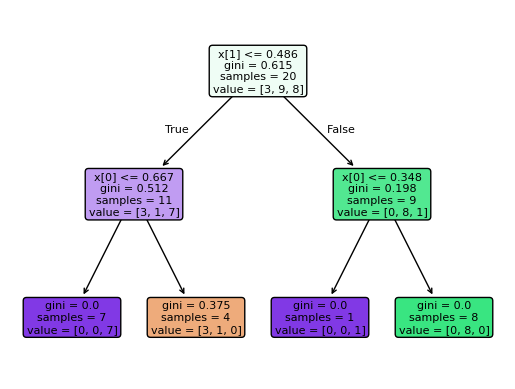

In [6]:
plot_tree(clf, filled=True, rounded=True, fontsize=8)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import ipywidgets as widgets                     # slider, output area, VBox
from IPython.display import display              # to display the VBox
from sklearn.tree import DecisionTreeClassifier, plot_tree

label_cmap = ListedColormap(["#1f77b4", "#ff7f0e", "#2ca02c"])


k_slider = widgets.IntSlider(value=3, min=2, max=10, step=1,
                             description="# of leafs (K):", continuous_update=False)

out = widgets.Output()

def redraw(k):
    out.clear_output(wait=True)
    clf = DecisionTreeClassifier(max_leaf_nodes=k, random_state=0).fit(X, y)

    xx, yy = np.meshgrid(np.linspace(0, 1, 300),
                         np.linspace(0, 1, 300))
    leaf_id = clf.apply(np.c_[xx.ravel(), yy.ravel()])
    uniq = np.unique(leaf_id)
    mapper = {lid: i for i, lid in enumerate(uniq)}
    zz = np.vectorize(mapper.get)(leaf_id).reshape(xx.shape)
    region_cmap = ListedColormap(plt.cm.Paired.colors[:len(uniq)])

    with out:
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))

        # left: decision regions + data
        axes[0].contourf(xx, yy, zz, alpha=0.25, cmap=region_cmap)
        axes[0].scatter(X[:, 0], X[:, 1], c=y, cmap=label_cmap,
                        edgecolor="k", s=100)
        axes[0].set(xlabel="$x_1$", ylabel="$x_2$",
                    xlim=(0, 1), ylim=(0, 1),
                    title=f"Decision regions (K = {k})")
        axes[0].grid(alpha=0.3)

        # right: tree diagram
        plot_tree(clf, ax=axes[1], impurity=False,
                  filled=True, rounded=True, fontsize=8)
        axes[1].set_title("Tree structure")

        plt.tight_layout()
        plt.show()

redraw(k_slider.value)
k_slider.observe(lambda c: redraw(c["new"]), names="value")

# --- display: plots first, slider underneath ---------------------
display(widgets.VBox([out, k_slider]))


 
**Example Algorithm: top-down “greedy” growth**

1. **Start** with all training data in the root node.
2. **For each candidate feature & split value**

   * Compute impurity reduction.
3. **Pick the best split.**
4. **Recurse** on each child node until a stopping rule triggers.
5. **Assign a prediction** to every terminal (leaf) node

   * Classification: majority class (or class probabilities).
   * Regression: mean (or median) target value.

> Greedy means each split is *locally* optimal; the algorithm does **not** revisit earlier splits.

> Check out the (much better) visualization by MLU:  https://mlu-explain.github.io/decision-tree/

### Pruning 

Decision trees tend to *overfit* the training data. CART combats this by **cost-complexity pruning**:

1. Build the **maximal tree** (until every leaf is pure or stops).
2. Generate a sequence of *nested pruned trees* $T_0 \supset T_1 \supset \ldots \supset T_k$ by iteratively removing the branch that produces the **smallest increase** in

   $$
   R_\alpha(T) = \text{Total error}(T) + \alpha \times |T_\text{leaves}|
   $$

   where $\alpha$ penalizes complexity.
3. Select the subtree with the lowest **cross-validated error**.


> Q: What does overfitting mean?  
> Note: Cross-validation will be discussed in model evaluation. 